Este agarra los datos del csv con la matriz de grayscale de cada espectrograma, y se los pasa al modelo de CNN de PyTorch (definido en aux file models.py), los guarda para poder llamarlo sin re-entrenar desde otros archivos

In [2]:
import os, sys
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch.nn.functional as F

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils import util, models, split as split

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == 'cuda':
    print(torch.cuda.get_device_name(device))
else:
    print("CUDA not available")

Using device: cuda
NVIDIA GeForce RTX 5080


In [4]:
# UNCOMMENT THE ONE BEING USED

# NOT NOISE-REDUCED
df = pd.read_csv(os.path.join('..', 'database', 'meta', 'final', 'train_data.csv'))

# NOISE-REDUCED
# df = pd.read_csv(os.path.join('..', 'database', 'meta', 'final', 'train_data2.csv'))

In [6]:
# Extract labels, authors, and pixel values
labels = df['label'].values.astype(np.int64)
authors = df['author'].values
features = df.drop(columns=['label', 'author']).values.astype(np.float32)
# Convert to 0-1 range first, then standardization will be applied per fold
features /= 255.0
features = features.reshape(-1, 1, 313, 224)

print("features shape:", features.shape)
print("labels shape:", labels.shape)
print("authors shape:", authors.shape)

# Create metadata DataFrame for splitting (with sample indices)
metadata_df = pd.DataFrame({
    'sample_idx': range(len(df)),
    'class_id': labels,
    'author': authors,
    'usable_segments': 1  # Each sample represents 1 segment
})

print("metadata_df shape:", metadata_df.shape)
print("Unique authors:", len(metadata_df['author'].unique()))
print("Unique classes:", len(metadata_df['class_id'].unique()))

features shape: (2387, 1, 313, 224)
labels shape: (2387,)
authors shape: (2387,)
metadata_df shape: (2387, 4)
Unique authors: 75
Unique classes: 31


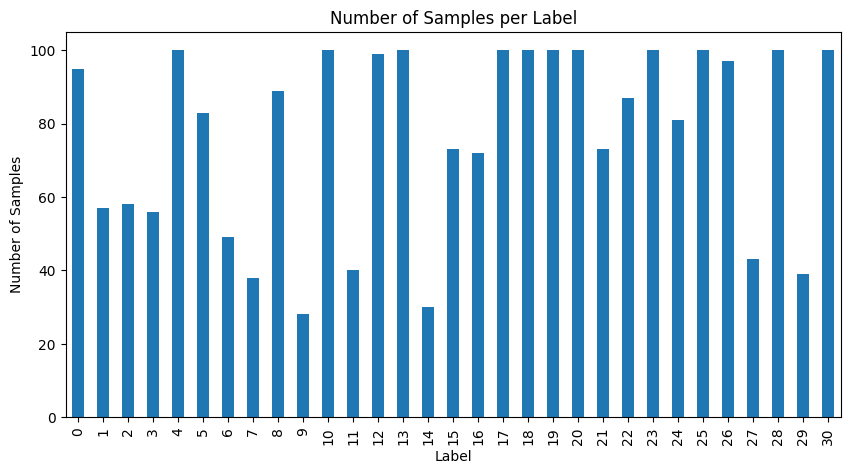

In [15]:
plt.figure(figsize=(10, 5))
df['label'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Label')
plt.ylabel('Number of Samples')
plt.title('Number of Samples per Label')
plt.show()

In [ ]:
import importlib
importlib.reload(models)
importlib.reload(util)
importlib.reload(split)

# Reload to pick up the StandardizedDataset fix and scheduler changes
from utils import util

In [17]:
# Prepare tensors
X_tensor = torch.tensor(features, dtype=torch.float32)
y_tensor = torch.tensor(labels, dtype=torch.long)
dataset = TensorDataset(X_tensor, y_tensor)

Finding best 4-fold split with author grouping...
Searching for best stratified 4-fold split across 10000 attempts...
Target validation segments per class per fold: {0: 24, 1: 14, 2: 14, 3: 14, 4: 25, 5: 21, 6: 12, 7: 10, 8: 22, 9: 7, 10: 25, 11: 10, 12: 25, 13: 25, 14: 8, 15: 18, 16: 18, 17: 25, 18: 25, 19: 25, 20: 25, 21: 18, 22: 22, 23: 25, 24: 20, 25: 25, 26: 24, 27: 11, 28: 25, 29: 10, 30: 25}
Attempt 0/9999...
New best 4-fold split found! Seed: 536, Avg Score: 0.592
Attempt 1000/9999...
Attempt 2000/9999...
New best 4-fold split found! Seed: 2247, Avg Score: 0.496
Attempt 3000/9999...
Attempt 4000/9999...
Attempt 5000/9999...
Attempt 6000/9999...
Attempt 7000/9999...
Attempt 8000/9999...
Attempt 9000/9999...

Best 4-fold split found:
Seed: 2247
Average stratification score: 0.496

Fold statistics:
Fold 1: Train=1753 segments, Val=634 segments
Fold 2: Train=1976 segments, Val=411 segments
Fold 3: Train=1715 segments, Val=672 segments
Fold 4: Train=1717 segments, Val=670 segments


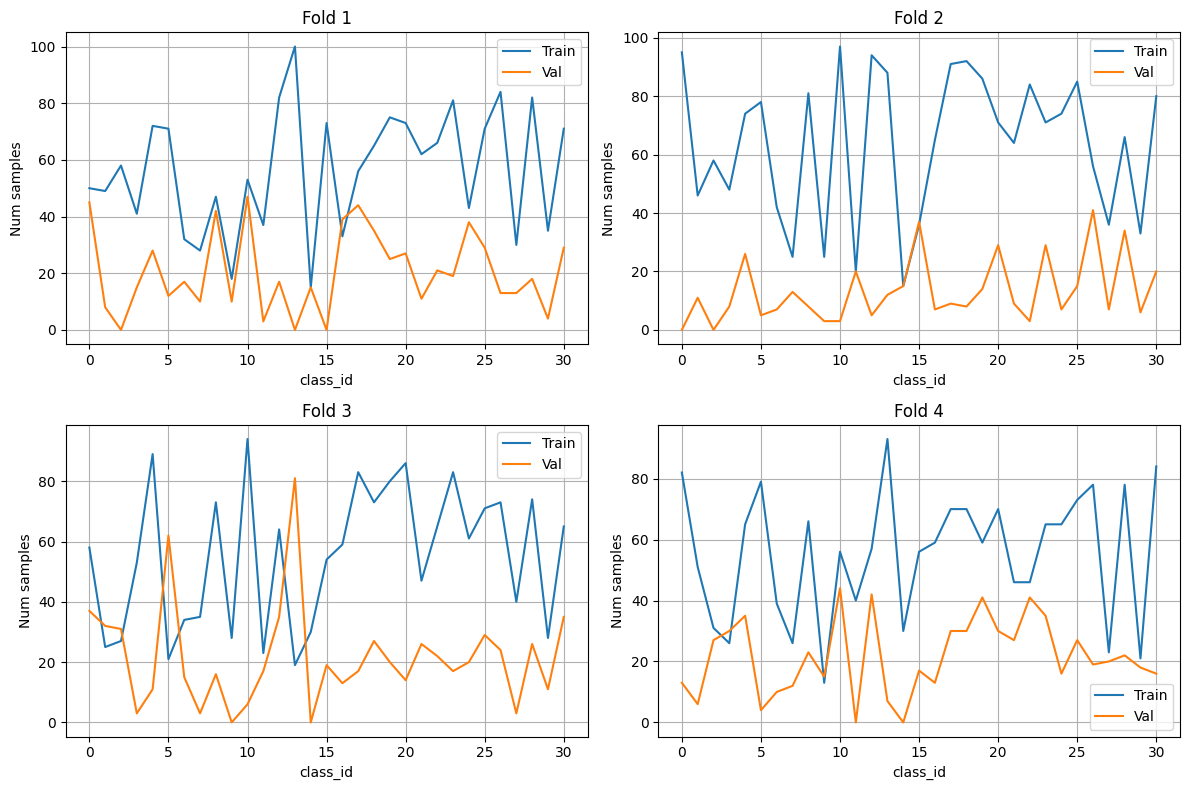


Best fold configuration found with seed 2247
Average stratification score: 0.496
Created 4 folds with proper author grouping


In [ ]:
# Find the best K-fold splits using author grouping
print("Finding best 4-fold split with author grouping...")
best_folds, best_score, best_seed = split.search_best_group_seed_kfold(
    df=metadata_df,
    max_attempts=30_000,
    min_val_segments=0,
    n_splits=4
)

In [18]:
print(f"\nBest fold configuration found with seed {best_seed}")
print(f"Average stratification score: {best_score:.3f}")

# Convert fold indices back to sample indices for dataset
fold_indices = []
for train_df, val_df in best_folds:
    train_indices = train_df['sample_idx'].values
    val_indices = val_df['sample_idx'].values
    fold_indices.append((train_indices, val_indices))

print(f"Created {len(fold_indices)} folds with proper author grouping")


Best fold configuration found with seed 2247
Average stratification score: 0.496
Created 4 folds with proper author grouping


Run to Train

In [ ]:
# Run K-Fold training with predefined folds and standardization
results, best_results = util.k_fold_cross_validation_with_predefined_folds(
    dataset=dataset,
    fold_indices=fold_indices,
    model_class=models.BirdCNN,
    num_classes=31,
    num_epochs=220,
    batch_size=24,
    lr=0.001,
    aggregate_predictions=True,
    use_class_weights=False,
    standardize=True
)

In [ ]:
# Plot accuracy and loss curves
util.plot_kfold_results(results, best_results)

leave this code commented for now

In [ ]:
# import cProfile

# cProfile.run(
#     "util.k_fold_cross_validation(dataset=dataset, model_class=models.BirdCNN, num_classes=28, k_folds=5, num_epochs=250, batch_size=48, lr=0.001, aggregate_predictions=True, random_state=435, use_class_weights=True)",
#     filename="../profiler/profile_output.prof"
# )

In [ ]:
# # Run K-Fold training with standardization
# results_unb, best_runb = util.k_fold_cross_validation(
#     dataset=dataset,
#     model_class=models.BirdCNN,
#     num_classes=28,
#     k_folds=5,
#     num_epochs=220,
#     batch_size=24,
#     lr=0.001,
#     aggregate_predictions=True,
#     random_state=1789,
#     use_class_weights=False,
#     standardize=True
# )

In [ ]:
# util.plot_kfold_results(results_unb, best_runb)

In [ ]:
# # Select Name, Best Fold, and Model
# model_name = 'bird_cnn'
# best_model_state = results['fold_results']['fold_3']['model_state']
# model = models.BirdCNN(num_classes=28).to(device)

# # ============= Don't modify below this line ============= Ensure variables above are set correctly ============
# model.load_state_dict(best_model_state)
# model_dir = os.path.join('..', 'models')
# os.makedirs(model_dir, exist_ok=True)
# save_path = os.path.join(model_dir, f"{model_name}.pth")

# util.save_model(model, model_name, model_save_path=save_path)
# util.test_saved_model(save_path)

Call Single Model

In [ ]:
# # Run single fold 80-20 training
# single_results = util.single_fold_training(
#     dataset=dataset,
#     model_class=models.BirdCNN,
#     num_classes=28,
#     num_epochs=250,
#     batch_size=48,
#     lr=0.001,
#     test_size=0.2,
#     random_state=435,
#     use_class_weights=True
# )

In [ ]:
# # Plot individual training curves
# util.plot_single_fold_curve(single_results, metric_key='accuracies', title="Single Fold - Accuracy Curves", ylabel="Accuracy")
# util.plot_single_fold_curve(single_results, metric_key='losses', title="Single Fold - Loss Curves", ylabel="Cross Entropy Loss")
# util.plot_single_fold_curve(single_results, metric_key='f1s', title="Single Fold - F1 Score Curves", ylabel="Macro F1 Score")

# # Print results summary
# util.print_single_fold_results(single_results)

# # Save the trained model
# util.save_model(single_results['model'], "bird_cnn_single_fold", model_save_path=os.path.join(model_dir, "bird_cnn_single_fold.pth"))